In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import maup
from zipfile import ZipFile
import numpy as np
import os
import shutil

# US Senate

In [2]:
#Read in election results
#unzip all county shapefiles
#read in all county shapefiles
#concatenate all files (same fields should keep it simple) - use a dictionary?

In [3]:
pwd

'/Users/lilyfalk/sandbox/pdv-va'

### Final File - Load

In [4]:
#Check out final file: https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/UBKYRU/FQDLOO&version=33.0 
final = gpd.read_file('./vest_va/va_2018_senate/va_2018_senate.shp')

In [5]:
final.head() #	G18USSOWRI = "Write-in Votes" from vest documentation

,COUNTYFP,LOCALITY,VTDST,PRECINCT,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI,geometry
0,001,Accomack County,000101,Chincoteague,556,994,17,0,"POLYGON Z ((-75.42507 37.89957 0.00000, -75.42..."
1,001,Accomack County,000201,Atlantic,182,459,11,0,"POLYGON Z ((-75.59978 37.87664 0.00000, -75.59..."
2,001,Accomack County,000202,Greenbackville,316,577,8,1,"POLYGON Z ((-75.49919 37.93416 0.00000, -75.49..."
3,001,Accomack County,000301,New Church,588,477,11,0,"POLYGON Z ((-75.64987 37.92702 0.00000, -75.64..."
4,001,Accomack County,000401,Bloxom,121,277,4,0,"POLYGON Z ((-75.71556 37.87513 0.00000, -75.71..."


# Election Results: US Senate 

In [6]:
#US senate results from the state: https://historical.elections.virginia.gov/elections/view/134055/ 
df = pd.read_csv('./vest_va/Virginia_Elections_Database__2018_U_S_Senate_General_Election_including_precincts.csv')

- Election race/Candidate name format change to match VEST
- precinct identifier change to match

In [7]:
df.head() #Ward not appearing, should it?

,County/City,Ward,Pct,Timothy Michael Kaine,Corey Alan Stewart,Matthew Joseph Waters,All Others,Total Votes Cast
0,NaN,NaN,NaN,Democratic,Republican,Libertarian,NaN,NaN
1,Accomack County,-,101 - Chincoteague,487,932,16,0,"1,435"
2,Accomack County,-,201 - Atlantic,159,430,10,0,599
3,Accomack County,-,202 - Greenbackville,277,541,7,1,826
4,Accomack County,-,301 - New Church,515,447,10,0,972


## Figure out overlap and rename accordingly to match final file

In [8]:
set(df['County/City']) - set(final['LOCALITY']) #account for totals later

{'TOTALS', nan}

RENAME COLUMNS BUT NO CONTENT CHANGE

In [9]:
df['LOCALITY'] = df['County/City']
df['G18USSDKAI'] = df['Timothy Michael Kaine']
df['G18USSRSTE'] = df['Corey Alan Stewart']
df['G18USSLWAT'] = df['Matthew Joseph Waters']
df['G18USSOWRI'] = df['All Others']
df = df.iloc[1:]
df = df.drop(['County/City', 'Ward', 'Timothy Michael Kaine', 'Corey Alan Stewart', 'Matthew Joseph Waters', 'All Others', 'Total Votes Cast'], axis = 1)
df.head()

,Pct,LOCALITY,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI
1,101 - Chincoteague,Accomack County,487,932,16,0
2,201 - Atlantic,Accomack County,159,430,10,0
3,202 - Greenbackville,Accomack County,277,541,7,1
4,301 - New Church,Accomack County,515,447,10,0
5,401 - Bloxom,Accomack County,106,260,4,0


In [10]:
(final['LOCALITY'] + final['VTDST'].str.slice(start = 3)).nunique()

2441

While the first three digits of `VTDST` are not always 0, locality combined with the last three of that code still has the same number of unique values.

## Format election results

In [11]:
#Add in county fips column to raw election results (df)
county_dict = pd.Series(final['COUNTYFP'].values, index = final['LOCALITY']).to_dict()
df['COUNTYFP'] = df['LOCALITY'].map(county_dict)

In [12]:
#Change type of election results so they can be summed, compared etc.
df.loc[:,'G18USSDKAI'] = df['G18USSDKAI'].map(lambda x: x.replace(',', ''))
df.loc[:,'G18USSRSTE'] = df['G18USSRSTE'].map(lambda x: x.replace(',', ''))
df.loc[:,'G18USSLWAT'] = df['G18USSLWAT'].map(lambda x: x.replace(',', ''))
df.loc[:,'G18USSOWRI'] = df['G18USSOWRI'].map(lambda x: x.replace(',', ''))
#added .loc to account for "copy" warning
df['G18USSDKAI'] = df['G18USSDKAI'].astype(str).astype(int)
df['G18USSRSTE'] = df['G18USSRSTE'].astype(str).astype(int)
df['G18USSLWAT'] = df['G18USSLWAT'].astype(str).astype(int)
df['G18USSOWRI'] = df['G18USSOWRI'].astype(str).astype(int)

In [13]:
#groupby in order to run preliminary sum checker
groupby_county_df = df.groupby('COUNTYFP').sum()
groupby_county_final = final.groupby(['COUNTYFP']).sum()

In [14]:
column_list = ['G18USSDKAI', 'G18USSRSTE', 'G18USSLWAT', 'G18USSOWRI']

In [15]:
df_final_groupby = pd.merge(groupby_county_df, groupby_county_final, on = 'COUNTYFP', how = 'inner', suffixes = ('_x', '_y'))

In [16]:
df_final_groupby.head()

,G18USSDKAI_x,G18USSRSTE_x,G18USSLWAT_x,G18USSOWRI_x,G18USSDKAI_y,G18USSRSTE_y,G18USSLWAT_y,G18USSOWRI_y
COUNTYFP,,,,,,,,
001,5997,6605,135,8,5997,6605,135,8
003,35701,16371,1161,93,35701,16371,1161,93
005,1952,3433,66,2,1952,3433,66,2
007,1938,3823,81,7,1938,3823,81,7
009,4541,7779,215,10,4541,7779,215,10


In [17]:
def sum_checker(df, column_list):
    list_max = 0
    for i in column_list:
        left_sum = df[i+'_x'].sum()
        right_sum = df[i+'_y'].sum()
        if (left_sum == right_sum):
            print('column: ', i, ' have the same sums')
        
        else:
            diff = abs(left_sum - right_sum)
            percent = abs(left_sum - right_sum)/left_sum
            print('column: ', i)
            print('RDH sum is ', str(left_sum))
            print('Partner sum is ', str(right_sum))
            print('their (absolute) difference is ', str(diff))
            print('As a percentage of DF1 this is ', str(round(percent*100,5)) + '%')
            if (percent>list_max):
                list_max = percent
            print('')
    print('The max difference (as a percent of the total of on DF column is: ', str(round(list_max,5)))

In [18]:
sum_checker(df_final_groupby, column_list)

column:  G18USSDKAI  have the same sums
column:  G18USSRSTE  have the same sums
column:  G18USSLWAT  have the same sums
column:  G18USSOWRI  have the same sums
The max difference (as a percent of the total of on DF column is:  0


**By county, results match** (great!)
Now need to re-allocate absentee/provisional votes to check by precinct

## Reallocate Absentee Votes

### Add cd to county name

In [19]:
cd_abs_prov_prec = df[((df['Pct'].map(lambda x: 'Absentee' in str(x))) &(df['Pct'].map(lambda x: 'CD' in str(x)))) | ((df['Pct'].map(lambda x: 'Provisional' in str(x))) & (df['Pct'].map(lambda x: 'CD' in str(x))))]

In [20]:
county_with_cd_nec_list = list(cd_abs_prov_prec['COUNTYFP'])

In [21]:
df['Pct'].str.slice(start = -5)[df['COUNTYFP'].isin(county_with_cd_nec_list)].value_counts()

CD 4)    179
CD 3)    160
D 11)    158
CD 7)    148
CD 8)     82
CD 1)     77
D 10)     68
CD 5)     48
CD 6)     39
CD 2)     38
CD 9)     33
Name: Pct, dtype: int64

In [22]:
def add_cd_to_county(county_list, precinct, countyfp):
    if (countyfp in county_list):
        countyfp_cd = countyfp + '-' + precinct[-5:-1]
        return countyfp_cd
    else:
        countyfp_cd = countyfp
        return countyfp_cd

In [23]:
df['countyfp_cd'] = df.apply(lambda row: add_cd_to_county(county_with_cd_nec_list, row['Pct'], row['COUNTYFP']), axis = 1)

In [24]:
df[df['COUNTYFP'].isin(county_with_cd_nec_list)]

,Pct,LOCALITY,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI,COUNTYFP,countyfp_cd
218,101 - Goodview Elem School (CD 5),Bedford County,310,1099,22,1,019,019-CD 5
219,102 - Hardy Vol Fire Co (CD 5),Bedford County,164,457,4,0,019,019-CD 5
220,103 - Chamblissburg Baptist Church (CD 5),Bedford County,264,776,10,0,019,019-CD 5
221,104 - Stewartsville Rescue Squad (CD 5),Bedford County,228,678,11,1,019,019-CD 5
222,201 - Bedford Christian Church (CD 5),Bedford County,152,402,6,0,019,019-CD 5
...,...,...,...,...,...,...,...,...
2501,706 - Huntersville (CD 3),Suffolk City,1436,192,22,2,800,800-CD 3
2502,AB - Central Absentee Precinct (CD 3),Suffolk City,1340,575,18,3,800,800-CD 3
2503,Ab - Central Absentee Precinct (CD 4),Suffolk City,715,242,7,1,800,800-CD 4
2504,Provisional (CD 3),Suffolk City,6,4,0,0,800,800-CD 3


In [25]:
df

,Pct,LOCALITY,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI,COUNTYFP,countyfp_cd
1,101 - Chincoteague,Accomack County,487,932,16,0,001,001
2,201 - Atlantic,Accomack County,159,430,10,0,001,001
3,202 - Greenbackville,Accomack County,277,541,7,1,001,001
4,301 - New Church,Accomack County,515,447,10,0,001,001
5,401 - Bloxom,Accomack County,106,260,4,0,001,001
...,...,...,...,...,...,...,...,...
2751,501 - Tabb,York County,1052,1369,53,6,199,199
2752,502 - Bethel,York County,1256,1113,53,2,199,199
2753,Ab - Central Absentee Precinct,York County,1366,1071,38,7,199,199
2754,Provisional,York County,13,12,2,0,199,199


### Actual Reallocation

In [26]:
def get_absentee_frac(prec_tot, county_tot, absentee_tot):
    '''A spec specifies in first line what function will do
    Returns fraction of county absentee votes for a precinct for a candidate
    
    Keyword arguments: (put inputs to funtions and say what they should be)
    precinct vote total for given candidate (int)
    county vote total for given candidate, absentee and provisional votes not included (int)
    absentee vote total for county for given candidate (int)
    
    "Pure function" bc only relies on inputs and outputs - only variables are ones that were passed as arguments
    '''
    if county_tot != 0:
        prec_frac = prec_tot/county_tot
        absentee_frac = prec_frac*absentee_tot
    else:
        absentee_frac = 0
    return absentee_frac

In [27]:
absentee_and_prov = df[(df['Pct'].map(lambda x: 'Absentee' in str(x))) | (df['Pct'].map(lambda x: 'Provisional' in str(x)))]
groupby_absentee_and_prov_tot = absentee_and_prov.groupby(['countyfp_cd']).sum()
groupby_county_df_tot = df.groupby(['countyfp_cd']).sum()
df_no_absent_or_provisional = df[(df['Pct'].map(lambda x: 'Absentee' not in str(x))) & (df['Pct'].map(lambda x: 'Provisional' not in str(x)))
                                & (df['LOCALITY'] != 'TOTALS')]
groupby_county_tot_no_absentee = df_no_absent_or_provisional.groupby('countyfp_cd').sum()

In [28]:
#NO ROUNDING OF TOTALS
df_with_absentee_reallocated = df_no_absent_or_provisional.copy()
for index, precinct_total_row_by_candidate in df_no_absent_or_provisional.iterrows():
    #print(precinct_total_row_by_candidate)
    county_fips = precinct_total_row_by_candidate['countyfp_cd']
    county_total_row_by_candidate_no_absentee = groupby_county_tot_no_absentee.loc[county_fips]
    county_absentee_and_provisional_by_candidate = groupby_absentee_and_prov_tot.loc[county_fips]
    #print(precinct_total_row_by_candidate, county_total_row_by_candidate_no_absentee, county_absentee_and_provisional_by_candidate)
    for candidate, votes in county_total_row_by_candidate_no_absentee.to_dict().items():
        prec_tot = precinct_total_row_by_candidate[candidate]
        #print('precinct total: ', prec_tot)
        county_tot = votes
        #print('county total: ', county_tot)
        absentee_tot = county_absentee_and_provisional_by_candidate[candidate]
        #print('absentee total: ', absentee_tot)
        absentee_frac = get_absentee_frac(prec_tot, county_tot, absentee_tot)
        #print('absentee votes to allocate to precinct: ', absentee_frac)
        prec_with_absentee_allocation = prec_tot + absentee_frac
        #print('new precinct total: ', prec_with_absentee_allocation)
        df_with_absentee_reallocated.loc[index, candidate] = prec_with_absentee_allocation #index is row, candidate is column

In [29]:
groupby_df_with_absentee_reallocated = df_with_absentee_reallocated.groupby('COUNTYFP').sum()
df_absentee_reallocate_with_final = pd.merge(groupby_df_with_absentee_reallocated, groupby_county_final, on = 'COUNTYFP', how = 'inner', suffixes = ('_x', '_y'))
df_absentee_reallocate_with_final

,G18USSDKAI_x,G18USSRSTE_x,G18USSLWAT_x,G18USSOWRI_x,G18USSDKAI_y,G18USSRSTE_y,G18USSLWAT_y,G18USSOWRI_y
COUNTYFP,,,,,,,,
001,5997.0,6605.0,135.0,8.0,5997,6605,135,8
003,35701.0,16371.0,1161.0,93.0,35701,16371,1161,93
005,1952.0,3433.0,66.0,2.0,1952,3433,66,2
007,1938.0,3823.0,81.0,7.0,1938,3823,81,7
009,4541.0,7779.0,215.0,10.0,4541,7779,215,10
...,...,...,...,...,...,...,...,...
800,21397.0,13397.0,461.0,37.0,21397,13397,461,37
810,91813.0,73575.0,3851.0,204.0,91813,73575,3851,204
820,3849.0,3713.0,149.0,7.0,3849,3713,149,7


In [30]:
sum_checker(df_absentee_reallocate_with_final, column_list) #Remember, totals not rounded here

column:  G18USSDKAI
RDH sum is  1910369.9999999998
Partner sum is  1910370
their (absolute) difference is  2.3283064365386963e-10
As a percentage of DF1 this is  0.0%

column:  G18USSRSTE  have the same sums
column:  G18USSLWAT  have the same sums
column:  G18USSOWRI
RDH sum is  5506.999999999999
Partner sum is  5509
their (absolute) difference is  2.0000000000009095
As a percentage of DF1 this is  0.03632%

The max difference (as a percent of the total of on DF column is:  0.00036


In [31]:
#WITH ROUNDING OF TOTALS
df_with_absentee_reallocated = df_no_absent_or_provisional.copy()
for index, precinct_total_row_by_candidate in df_no_absent_or_provisional.iterrows():
    #print(precinct_total_row_by_candidate)
    county_fips = precinct_total_row_by_candidate['countyfp_cd']
    county_total_row_by_candidate_no_absentee = groupby_county_tot_no_absentee.loc[county_fips]
    county_absentee_and_provisional_by_candidate = groupby_absentee_and_prov_tot.loc[county_fips]
    #print(precinct_total_row_by_candidate, county_total_row_by_candidate_no_absentee, county_absentee_and_provisional_by_candidate)
    for candidate, votes in county_total_row_by_candidate_no_absentee.to_dict().items():
        prec_tot = precinct_total_row_by_candidate[candidate]
        #print('precinct total: ', prec_tot)
        county_tot = votes
        #print('county total: ', county_tot)
        absentee_tot = county_absentee_and_provisional_by_candidate[candidate]
        #print('absentee total: ', absentee_tot)
        absentee_frac = get_absentee_frac(prec_tot, county_tot, absentee_tot)
        #print('absentee votes to allocate to precinct: ', absentee_frac)
        prec_with_absentee_allocation = prec_tot + absentee_frac
        #print('new precinct total: ', prec_with_absentee_allocation)
        df_with_absentee_reallocated.loc[index, candidate] = round(prec_with_absentee_allocation) #index is row, candidate is column

   

In [32]:
groupby_df_with_absentee_reallocated = df_with_absentee_reallocated.groupby('COUNTYFP').sum()
df_absentee_reallocate_with_final = pd.merge(groupby_df_with_absentee_reallocated, groupby_county_final, on = 'COUNTYFP', how = 'inner', suffixes = ('_x', '_y'))
sum_checker(df_absentee_reallocate_with_final, column_list) #REMEMBER, TOTALS ARE ROUNDED HERE

column:  G18USSDKAI
RDH sum is  1910373.0
Partner sum is  1910370
their (absolute) difference is  3.0
As a percentage of DF1 this is  0.00016%

column:  G18USSRSTE  have the same sums
column:  G18USSLWAT
RDH sum is  61505.0
Partner sum is  61565
their (absolute) difference is  60.0
As a percentage of DF1 this is  0.09755%

column:  G18USSOWRI
RDH sum is  5350.0
Partner sum is  5509
their (absolute) difference is  159.0
As a percentage of DF1 this is  2.97196%

The max difference (as a percent of the total of on DF column is:  0.02972


# Shapefiles: County to Pct

## Load, Project

In [33]:
#All counties found: https://www.census.gov/geo/partnerships/pvs/partnership19v2/st51_va.html <-- careful, need to pay close attention to url to makesure get vtds
os.listdir('./vest_va/census_shps_by_county_all_unzip/')

['partnership_shapefiles_19v2_51580',
 'partnership_shapefiles_19v2_51117',
 'partnership_shapefiles_19v2_51121',
 'partnership_shapefiles_19v2_51119',
 'partnership_shapefiles_19v2_51770',
 'partnership_shapefiles_19v2_51181',
 'partnership_shapefiles_19v2_51175',
 'partnership_shapefiles_19v2_51143',
 'partnership_shapefiles_19v2_51520',
 'partnership_shapefiles_19v2_51127',
 'partnership_shapefiles_19v2_51740',
 'partnership_shapefiles_19v2_51111',
 'partnership_shapefiles_19v2_51145',
 'partnership_shapefiles_19v2_51510',
 'partnership_shapefiles_19v2_51187',
 'partnership_shapefiles_19v2_51173',
 'partnership_shapefiles_19v2_51001',
 'partnership_shapefiles_19v2_51650',
 '.DS_Store',
 'partnership_shapefiles_19v2_51037',
 'partnership_shapefiles_19v2_51063',
 'partnership_shapefiles_19v2_51097',
 'partnership_shapefiles_19v2_51099',
 'partnership_shapefiles_19v2_51009',
 'partnership_shapefiles_19v2_51660',
 'partnership_shapefiles_19v2_51036',
 'partnership_shapefiles_19v2_51031'

In [34]:
#unzip file function
def unzip(path, src_path, dest_path, zip_file_name, unzipped_file_name):
    os.chdir(path)
    with ZipFile(zip_file_name, 'r') as zipObj:
        zipObj.extractall(unzipped_file_name) 
        
    shutil.move(src_path, dest_path)

In [35]:
#unzip multiple files in directory
def unzip_mult_files(path, new_dir_path):
    if not path[0] == '.':
        os.chdir(path)
        for zipfile in os.listdir():
            if not zipfile[0] == '.' and not zipfile == 'partnership_shapefiles_19v2_51.zip':
                if zipfile.endswith('.zip'): 
                    unzipped_file_name = zipfile[:-4]
                    src_path = os.path.join(path, unzipped_file_name)
                    dest_path = new_dir_path #os.path.join(new_dir_path, unzipped_file_name)
                    unzip(path, src_path, dest_path, zipfile, unzipped_file_name)
                    
'''
path = ('./vest_va/test_dir1/')
new_dir_path = './vest_va/test_dir'
unzip_mult_files(path, new_dir_path)'''

"\npath = ('./vest_va/test_dir1/')\nnew_dir_path = './vest_va/test_dir'\nunzip_mult_files(path, new_dir_path)"

In [36]:
#unzip files in multiple directories
def unzip_in_mult_directories(path, new_dir_path):
    os.chdir(path)
    for directory in os.listdir():
        if not directory[0] == '.':
            sub_dir = os.path.join(path, directory)
            unzip_mult_files(sub_dir, new_dir_path)
            os.chdir(path)
            
'''
path = './vest_va/census_shps_by_county_dir_unzip/'
new_dir_path = './vest_va/census_shps_by_county_all_unzip'
unzip_in_mult_directories(path, new_dir_path)'''

"\npath = './vest_va/census_shps_by_county_dir_unzip/'\nnew_dir_path = './vest_va/census_shps_by_county_all_unzip'\nunzip_in_mult_directories(path, new_dir_path)"

In [37]:
county_fips = []
for directory in os.listdir('./vest_va/census_shps_by_county_all_unzip/'):
    if not directory[0] == '.':
        county_fips.append(directory[-5:])

In [38]:
len(county_fips) #As expected

133

In [39]:
proj = final.crs

In [40]:
#Now need function that will read in and concatenate all VTD shapefiles
#Note that last 5 digits of directory and file are state fip (51) plus county fip (3-digit)
county_vtds = []

for i in county_fips: #i dont have fips_codes file
    ref = './vest_va/census_shps_by_county_all_unzip/partnership_shapefiles_19v2_'
    vtd_ref = ref + i + '/PVS_19_v2_vtd_' + i + '.shp' 
    vtd_shp = gpd.read_file(vtd_ref)
    print(i, ' added to list')
    county_vtds.append(vtd_shp)

51580  added to list
51117  added to list
51121  added to list
51119  added to list
51770  added to list
51181  added to list
51175  added to list
51143  added to list
51520  added to list
51127  added to list
51740  added to list
51111  added to list
51145  added to list
51510  added to list
51187  added to list
51173  added to list
51001  added to list
51650  added to list
51037  added to list
51063  added to list
51097  added to list
51099  added to list
51009  added to list
51660  added to list
51036  added to list
51031  added to list
51007  added to list
51053  added to list
51065  added to list
51091  added to list
51047  added to list
51071  added to list
51085  added to list
51049  added to list
51620  added to list
51680  added to list
51025  added to list
51013  added to list
51810  added to list
51077  added to list
51083  added to list
51079  added to list
51610  added to list
51041  added to list
51015  added to list
51023  added to list
51820  added to list
51169  added 

In [42]:
global shapefiles_census
shapefiles_census = gpd.GeoDataFrame(pd.concat(county_vtds, axis = 0) , crs = proj) 

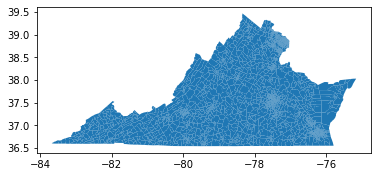

In [43]:
shapefiles_census.plot()

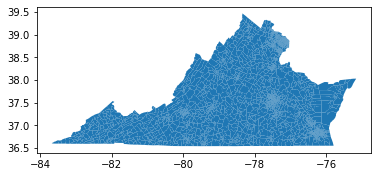

In [44]:
final.plot()

## Examples of merges noted in documentation

Merges noted in documentation are geometry changes that we will not be modifying.

**From VEST documentation:**

The following modifications were made to recreate the 2018 precinct boundaries.

- Albemarle: Add Mechums River to match county GIS shapefile
- Arlington: Adjust Gunston/Oakridge to match county GIS shapefile
- Bristol City: Adjust Ward 2/Ward 4 to match description in municipal code
- Charles City County: Adjust District 1/District 2 boundary to match county code
- Covington City: Realign Ward 1, Ward 2, Ward 3 to match city PDF map and municipal code
- Culpeper: Adjust East Fairfax/Brandy Station boundary to match county GIS shapefile
- Emporia City: Adjust Precincts 1/7, Precincts 2/5 to match municipal code
- Essex: Adjust South Precinct/Central Precinct boundary to match county PDF
- Fairfax: Adjust Virginia Run/Bull Run to match county GIS shapefile
- Fredericksburg City: Adjust District 1/3 boundaries to match municipal code
- Galax City: Adjust North/South precinct boundary to match municipal GIS shapefile
- Goochland: Adjust Hadensville/Fife boundary to match description in county code
- Halifax: Merge South Boston East/West; Adjust Meadville/Republican Grove to match 2011 redistricting PDF map
- Hampton City: Add US House District 2 segment of Tyler Precinct to match county PDF
- Hanover: Adjust Blunts/Beaverdam boundary to match county PDF
- Henry: Adjust 10 precinct boundaries to align VTDs with county GIS shapefile
- Loudoun: Adjust Weller/Ashbrook, Evergreen/Sycolin Creek; Add Goshen Post, Buffalo Trail to match county GIS shapefile
- Madison: Adjust all precincts to align VTDs with county GIS shapefile
- Newport News City: Adjust Sanford/Riverview boundary to match county GIS shapefile
- Norfolk City: Merge Bramblewood into Chesterfield/Ruffner Academy; Adjust Granby/Titustown to match county PDF
- Prince William: Adjust Ben Lomond/Mullen, Freedom/Leesylvania to match county GIS shapefile
- Pulaski: Adjust Dublin/New River to match precinct assignments on county GIS parcel viewer
- Rappahanock: Adjust Sperryville/Washington boundary to match county PDF
- Richmond City: Add Precinct 115 to match county GIS shapefile
- Richmond County: Adjust Precincts 2-1/3-1 boundary to match description in county ordinance
- Roanoke County: Adjust 12 precinct boundaries to match county GIS shapefile
- Rockingham: Split East/West Bridgewater to match municipal ordinance; Adjust East Bridgewater to match municipal boundary
- Russell: Adjust Daugherty/West Lebanon boundary to match county PDF
- Tazewell: Merge Abbs Valley/Bossevain, Adria/Gap Store, Pounding Mill/Wardell, Raven/Richlands;  Adjust nearly all precinct boundaries to align VTDs with county GIS shapefile
- Virginia Beach City: Adjust Centerville/Colonial to match county GIS shapefile
- Williamsburg City: Revise Matoaka/Stryker to match municipal PDF map and municipal code
- Wise: Adjust Big Stone Gap/East Stone Gap boundary to match county GIS shapefile
- Wythe: Adjust West Wytheville/East Wytheville boundary to match county GIS shapefile

In [42]:
# 'Albemarle: Add Mechums River to match county GIS shapefile'
df[df['LOCALITY'].map(lambda x: 'Albemarle' in str(x)) & df['Pct'].map(lambda x: 'Mechums' in str(x))]

,Pct,LOCALITY,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI,COUNTYFP
48,606 - Mechums River,Albemarle County,1426,695,61,4,003


In [43]:
# 'Arlington: Adjust Gunston/Oakridge to match county GIS shapefile'
df[(df['LOCALITY'].map(lambda x: 'Arlington' in str(x)) & df['Pct'].map(lambda x: 'Gunston' in str(x)))] 

,Pct,LOCALITY,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI,COUNTYFP
177,52 - Gunston,Arlington County,1092,193,41,8,013


In [44]:
final[(final['LOCALITY'].map(lambda x: 'Arlington' in str(x)) & final['PRECINCT'].map(lambda x: 'Gunston' in str(x)))]

,COUNTYFP,LOCALITY,VTDST,PRECINCT,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI,geometry
2418,013,Arlington County,000052,Gunston,1375,224,47,9,"POLYGON Z ((-77.08225 38.84343 0.00000, -77.08..."


In [45]:
df[(df['LOCALITY'].map(lambda x: 'Arlington' in str(x)) & df['Pct'].map(lambda x: 'Oakridge' in str(x)))]

,Pct,LOCALITY,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI,COUNTYFP
157,32 - Oakridge,Arlington County,577,179,21,4,013


## Finding Unique Identifier

In [45]:
shp = shapefiles_census
shp.shape

(2462, 16)

In [46]:
final.shape 

(2463, 9)

In [47]:
df_with_absentee_reallocated.shape

(2462, 8)

In [48]:
(df_with_absentee_reallocated.COUNTYFP + df_with_absentee_reallocated.Pct.str.slice(stop = 3)).value_counts()

800404    2
800302    2
153609    2
710104    2
095504    2
         ..
107311    1
087220    1
191202    1
053402    1
0134 -    1
Length: 2440, dtype: int64

In [49]:
df_with_absentee_reallocated[(df_with_absentee_reallocated.Pct.str.slice(stop = 3) == '304') & (df_with_absentee_reallocated.COUNTYFP == '089')]

,Pct,LOCALITY,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI,COUNTYFP,countyfp_cd
1316,304 - Mount Olivet (CD 5),Henry County,723.0,563.0,9.0,0.0,089,089-CD 5
1317,304 - Mount Olivet (CD 9),Henry County,4.0,0.0,0.0,0.0,089,089-CD 9


In [50]:
df_county_vtdst = set(df_with_absentee_reallocated.COUNTYFP + df_with_absentee_reallocated.Pct.str.slice(stop = 3))

In [51]:
(shp.COUNTYFP + shp.VTDST).nunique()

2462

Match rate for final and vtdst pretty good - if get all 2440/2462 to match, that is a 99.1% match rate... Just need to fix final file leading zeros etc with vtdst

See below with unique IDs are missing

In [52]:
nonunique_id = ['650215', '177703', '089304', '177402', '800602', '153112', '059513',
       '800504', '095202', '800404', '550020', '089505', '800302', '153609',
       '153210', '177103', '710104', '153110', '177702', '095504', '153312',
       '177704']

In [53]:
final['unique_id'] = final.COUNTYFP + final.VTDST.str.slice(start = 3)

In [54]:
len(final[final['unique_id'].isin(nonunique_id)])

44

In [55]:
final[(final.VTDST.str.slice(start = 3) == '215') & (final.COUNTYFP == '650')]

,COUNTYFP,LOCALITY,VTDST,PRECINCT,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI,geometry,unique_id
1803,650,Hampton City,000215,TYLER (CD 3),363,62,10,5,"POLYGON Z ((-76.36283 37.05127 0.00000, -76.36...",650215
2239,650,Hampton City,000215,TYLER (CD 2),38,9,1,0,"POLYGON Z ((-76.36144 37.05458 0.00000, -76.35...",650215


In [56]:
df_with_absentee_reallocated['vtdst'] = df_with_absentee_reallocated.Pct.str.slice(stop = 3)

In [57]:
#Now, tackle the case where vtdst messed up in df - add vtdst column
def vtdst_changer(vtdst):
    if (vtdst[1:3] == ' -'):
        two_lead_zero = '00' + vtdst[:1]
        return two_lead_zero
    elif (vtdst[1:3] == '- '):
        two_lead_zero = '00' + vtdst[:1]
        return two_lead_zero
    elif (vtdst[-1:] == ' '):
        one_lead_zero = '0' + vtdst[:2]
        return one_lead_zero
    elif (vtdst[-1:] == '-'):
        one_lead_zero = '0' + vtdst[:2]
        return one_lead_zero
    else:
        return vtdst
    

In [58]:
df_with_absentee_reallocated['vtdst'] = df_with_absentee_reallocated['vtdst'].apply(vtdst_changer)

In [59]:
((df_with_absentee_reallocated['COUNTYFP']+ df_with_absentee_reallocated['vtdst'])).nunique()

2440

In [60]:
(df_with_absentee_reallocated['COUNTYFP'] + df_with_absentee_reallocated['Pct'].str.slice(stop = 3)).nunique()

2440

In [61]:
df_with_absentee_reallocated[df_with_absentee_reallocated['vtdst'].str.slice(start = -1) == '-']

,Pct,LOCALITY,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI,COUNTYFP,countyfp_cd,vtdst


Now, with vtdst in each set, make unique ID from the 2440 that do match, then account for the 10/20 that dont afterward.

In [62]:
df_with_absentee_reallocated['unique_id'] = df_with_absentee_reallocated['COUNTYFP'] + df_with_absentee_reallocated['vtdst']

In [63]:
double_in_df = df_with_absentee_reallocated['unique_id'].value_counts()
df_double_list = double_in_df[double_in_df > 1].index
double_in_final = final['unique_id'].value_counts()
final_double_list = double_in_final[double_in_final > 1].index
print(set(final_double_list) - set(df_double_list))
print(set(df_double_list) - set(final_double_list))

set()
set()


In [64]:
final['PRECINCT'].str.slice(start = -6)[final['unique_id'].isin(list(df_double_list))]

1803    (CD 3)
2232    (CD 4)
2233    (CD 3)
2234    (CD 8)
2235    CD 11)
2239    (CD 2)
2241    (CD 1)
2242    (CD 2)
2267    (CD 2)
2268    (CD 3)
2270    (CD 1)
2271    CD 11)
2272    (CD 1)
2273    (CD 1)
2274    CD 10)
2275    CD 10)
2276    CD 11)
2277    (CD 1)
2278    CD 11)
2279    (CD 1)
2284    (CD 7)
2285    (CD 1)
2286    (CD 1)
2287    (CD 7)
2288    (CD 1)
2289    (CD 7)
2290    (CD 1)
2291    (CD 7)
2292    (CD 7)
2293    (CD 1)
2294    (CD 4)
2295    (CD 4)
2296    (CD 3)
2297    (CD 4)
2298    (CD 3)
2299    (CD 4)
2300    (CD 3)
2301    (CD 3)
2302    (CD 1)
2303    (CD 2)
2313    (CD 9)
2314    (CD 5)
2315    (CD 5)
2316    (CD 9)
Name: PRECINCT, dtype: object

In [65]:
def vtdst_add_cd(unique_id, precinct):
    double_list = ['177702', '153112', '710104', '800602', '095504', '177103', '089505',
       '800404', '800504', '153210', '095202', '089304', '800302', '153609',
       '177703', '650215', '177402', '153312', '059513', '550020', '177704',
       '153110']
    if (unique_id in double_list):
        unique_id = unique_id + precinct[-6:]
        return unique_id
    else:
        return unique_id

In [66]:
df_with_absentee_reallocated['unique_id_1'] = df_with_absentee_reallocated.apply(lambda row: vtdst_add_cd(row['unique_id'], row['Pct']), axis = 1)
df_with_absentee_reallocated['unique_id_1'].nunique()

2462

In [67]:
final['unique_id_1'] = final.apply(lambda row: vtdst_add_cd(row['unique_id'], row['PRECINCT']), axis = 1)

In [68]:
df_with_absentee_reallocated['unique_id_1'][df_with_absentee_reallocated['unique_id'].isin(list(df_double_list))]

425     550020(CD 3)
426     550020(CD 4)
787     059513CD 11)
788     059513(CD 8)
1157    650215(CD 2)
1158    650215(CD 3)
1316    089304(CD 5)
1317    089304(CD 9)
1327    089505(CD 5)
1328    089505(CD 9)
1374    095202(CD 1)
1375    095202(CD 2)
1388    095504(CD 1)
1389    095504(CD 2)
1764    710104(CD 2)
1765    710104(CD 3)
2001    153110(CD 1)
2002    153110CD 10)
2004    153112(CD 1)
2005    153112CD 10)
2015    153210(CD 1)
2016    153210CD 11)
2033    153312(CD 1)
2034    153312CD 11)
2072    153609(CD 1)
2073    153609CD 11)
2402    177103(CD 1)
2403    177103(CD 7)
2413    177402(CD 1)
2414    177402(CD 7)
2425    177702(CD 1)
2426    177702(CD 7)
2427    177703(CD 1)
2428    177703(CD 7)
2429    177704(CD 1)
2430    177704(CD 7)
2479    800302(CD 3)
2480    800302(CD 4)
2486    800404(CD 3)
2487    800404(CD 4)
2491    800504(CD 3)
2492    800504(CD 4)
2494    800602(CD 3)
2495    800602(CD 4)
Name: unique_id_1, dtype: object

In [69]:
set(final['unique_id_1']) - set(df_with_absentee_reallocated['unique_id_1'])

{'003499', '003599', '059700'}

In [70]:
set(df_with_absentee_reallocated['unique_id_1']) - set(final['unique_id_1'])

{'003407', '003507'}

In [71]:
df_not_in_final = list(set(df_with_absentee_reallocated['unique_id_1']) - set(final['unique_id_1']))

In [72]:
df_with_absentee_reallocated[df_with_absentee_reallocated['unique_id_1'].isin(df_not_in_final)]

,Pct,LOCALITY,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI,COUNTYFP,countyfp_cd,vtdst,unique_id,unique_id_1
37,407 - Biscuit Run,Albemarle County,1083.0,253.0,47.0,2.0,003,003,407,003407,003407
43,507 - Pantops,Albemarle County,1055.0,454.0,23.0,2.0,003,003,507,003507,003507


In [73]:
final_notin_df = list(set(final['unique_id_1']) - set(df_with_absentee_reallocated['unique_id_1']))

In [74]:
final[final['unique_id_1'].isin(final_notin_df)]

,COUNTYFP,LOCALITY,VTDST,PRECINCT,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI,geometry,unique_id,unique_id_1
29,003,Albemarle County,000499,Biscuit Run,1083,252,47,2,"POLYGON Z ((-78.53848 37.98576 0.00000, -78.53...",003499,003499
600,059,Fairfax County,000700,Fairfax Court,0,0,0,0,"POLYGON Z ((-77.31648 38.84615 0.00000, -77.31...",059700,059700
2332,003,Albemarle County,000599,Pantops,1054,453,23,2,"POLYGON Z ((-78.45505 38.04404 0.00000, -78.45...",003599,003599


### Fixing 07 vs 99 problem

In [75]:
d = {'003407':'003499', '003507': '003599'}

In [76]:
df_with_absentee_reallocated.loc[df_with_absentee_reallocated['unique_id'].isin(d.keys()), 'unique_id_1']=df_with_absentee_reallocated.loc[df_with_absentee_reallocated['unique_id'].isin(d.keys()), 'unique_id_1'].map(d)

In [77]:
df_with_absentee_reallocated.loc[df_with_absentee_reallocated['unique_id'].isin(d.keys())]#, 'unique_id_1']

,Pct,LOCALITY,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI,COUNTYFP,countyfp_cd,vtdst,unique_id,unique_id_1
37,407 - Biscuit Run,Albemarle County,1083.0,253.0,47.0,2.0,003,003,407,003407,003499
43,507 - Pantops,Albemarle County,1055.0,454.0,23.0,2.0,003,003,507,003507,003599


In [78]:
final.loc[final['unique_id'] == '003499']

,COUNTYFP,LOCALITY,VTDST,PRECINCT,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI,geometry,unique_id,unique_id_1
29,003,Albemarle County,000499,Biscuit Run,1083,252,47,2,"POLYGON Z ((-78.53848 37.98576 0.00000, -78.53...",003499,003499


In [79]:
final.unique_id_1.nunique()

2463

In [80]:
df_with_absentee_reallocated.unique_id_1.nunique()

2462

### Apply unique id to shp

In [81]:
shp['unique_id'] = shp['COUNTYFP'] + shp['VTDST'].str.slice(start = 3)

In [82]:
shp.shape

(2462, 17)

In [83]:
df_notin_shp = list(set(df_with_absentee_reallocated['unique_id']) - set(shp['unique_id']))

In [84]:
df_with_absentee_reallocated[df_with_absentee_reallocated['unique_id'].isin(df_notin_shp)]

,Pct,LOCALITY,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI,COUNTYFP,countyfp_cd,vtdst,unique_id,unique_id_1
278,4 - Fourth Ward,Bristol City,610.0,1581.0,24.0,2.0,520,520,004,520004,520004
446,40 - River Birch (CD 3),Chesapeake City,1215.0,750.0,29.0,3.0,550,550-CD 3,040,550040,550040
453,47 - Green Sea (CD 4),Chesapeake City,311.0,513.0,15.0,2.0,550,550-CD 4,047,550047,550047
1086,401 - Fries,Grayson County,101.0,224.0,4.0,0.0,077,077,401,077401,077401
1372,104- Berkeley D (CD 2),James City County,463.0,326.0,19.0,1.0,095,095-CD 2,104,095104,095104
1616,3 - Precinct Three,Manassas Park City,953.0,464.0,28.0,0.0,685,685,003,685003,685003
1997,106 - Westgate (CD 1),Prince William County,974.0,260.0,26.0,2.0,153,153-CD 1,106,153106,153106
2681,702 - Wallace,Washington County,132.0,449.0,7.0,1.0,191,191,702,191702,191702


In [85]:
shp_notin_df = list(set(shp['unique_id']) - set(df_with_absentee_reallocated['unique_id']))

In [81]:
shp[(shp['COUNTYFP'] == '153')  & (shp['VTDST'].str.slice(start = 3) == '112')]

,STATEFP,COUNTYFP,VTDST,NAMELSAD,VTDI,LSAD,CHNG_TYPE,ORIG_NAME,ORIG_CODE,RELATE,NAME,VINTAGE,FUNCSTAT,JUSTIFY,MTFCC,geometry,unique_id
9,51,153,000112,Burke-Nickens Voting District,A,V2,None,None,None,None,Burke-Nickens,90,N,None,G5240,"POLYGON Z ((-77.70994 38.82376 0.00000, -77.70...",153112


### Refine unique id match to increase match between election results and shp

In [86]:
shp_id_list = list(set(shp['unique_id']) - set(df_with_absentee_reallocated['unique_id']))
df_id_list = list(set(df_with_absentee_reallocated['unique_id']) - set(shp['unique_id']))

In [87]:
print(shp.shape[0])
print(len(shp_id_list))
print(df_with_absentee_reallocated.shape[0])
len(df_id_list)

2462
29
2462


8

In [89]:
set(['191702',
 '550047',
 '095104',
 '520004',
 '077401',
 '685003',
 '550040',
 '153106']) - set(df_id_list) #list on left from US House where initial match done to see if descrepencies match in Senate file.

set()

In [90]:
set(shp_id_list) - set(['121032',
 '041216',
 '510309',
 '041113',
 '550064',
 '153061',
 '153114',
 '059700',
 '191021',
 '510112',
 '041412',
 '153062',
 '685032',
 '760215',
 '191022',
 '041314',
 '153315',
 '095041',
 '760415',
 '520042',
 '550065',
 '095042',
 '685031',
 '041319',
 '750004',
 '520041',
 '077012',
 '161401',
 '077011'])

set()

**adapted from us house file - over lap same? - yes**

See house file to see hand matching

In [91]:
#important
# shp:df
merge_dict = {'153114': '153109', #? do not look like they matchPiney Branch
 '153061': '153106', #Westgate part 1 -- on map looks like it this is the only match ?merge
 '153062': '153106', #?merge Westgate part 2 -- westgate is normal Polygon z in final file
 #: 153315 - Williams voting District from shp does not seem to have a match in df
 '191021': '191702', #merge Wallace part 1
 '191022': '191702', #merge Wallace part 2 -- multipolygon in final file - merge shp
 '760415': '760114', #? does not look like it matches based on polygons only one that contains 4 that is not in shp file also??
 #no match in 760 county for : 760215 from shp dataset
 #no match in 750 county for : '750004'
 '685031': '685003', #merge Precint three part 1
 '685032': '685003', #merge Precinct three part 2
 #: 059700 -- no match - in Final and shp, not in df -- zero votes
 '095041': '095104', #merge Berkeley part 1
 '095042': '095104', #merge Berkeley part 2
 '161401': '161405', # merge with exsiting 161405 "North LINDENWOOD" with this "South LINDENWOOD"
 '550064': '550006', # merge Deep creek II -- merge with existing 550006
 '550065': '550049', # merge Waterway II -- merge with exisiting 550049
 '041113': '041111', # merge with existing 041111
 '077011': '077401', #merge Fries part 1 - merge
 '077012': '077401', #merge Fries part 2 - merge
 #: 510302 and 
 #: 510112 do not seem to have matches in df from shp
 '520041': '520004', #merge Fourth Ward Part 1
 '520042': '520004', #merge Fourth Ward Part 2
 '121032': '121203', #vtdst = 002032 - B3 part 2 merge with part 1 existing (121203)
 #'121032': '121403-9' #vtdst = 004032 - D3 part 2 - merge with part 1 existing -- this and previous need new ID to distinguish ... or not just cut it ?121032 does not match the final version
    #'550040-3': , #River birch missing in shp
    #'550047-4':  #Green Sea missing in shp
} 

In [93]:
set(merge_dict.values()) - set(df_with_absentee_reallocated.unique_id_1)

set()

In [94]:
#important 
shp['unique_id_1'] = shp['unique_id']
shp.loc[shp['unique_id'].isin(merge_dict.keys()), 'unique_id_1'] = shp.loc[shp['unique_id'].isin(merge_dict.keys()), 'unique_id_1'].map(merge_dict)
shp.loc[shp['unique_id'].isin(merge_dict.keys())]

,STATEFP,COUNTYFP,VTDST,NAMELSAD,VTDI,LSAD,CHNG_TYPE,ORIG_NAME,ORIG_CODE,RELATE,NAME,VINTAGE,FUNCSTAT,JUSTIFY,MTFCC,geometry,unique_id,unique_id_1
23,51,121,002032,B-3 part 2,A,00,None,None,None,None,B-3 part 2,90,N,None,G5240,"POLYGON Z ((-80.44921 37.16344 0.00000, -80.44...",121032,121203
24,51,121,004032,D-3 part 2,A,00,None,None,None,None,D-3 part 2,90,N,None,G5240,"POLYGON Z ((-80.51937 37.13193 0.00000, -80.51...",121032,121203
3,51,520,000041,Fourth Ward Part 1 Voting District,P,V2,None,None,None,None,Fourth Ward Part 1,90,S,None,G5240,"POLYGON Z ((-82.16028 36.62071 0.00000, -82.15...",520041,520004
4,51,520,000042,Fourth Ward Part 2 Voting District,P,V2,None,None,None,None,Fourth Ward Part 2,90,S,None,G5240,"POLYGON Z ((-82.12869 36.64952 0.00000, -82.12...",520042,520004
14,51,077,004011,Fries Part 1 Voting District,P,V2,None,None,None,None,Fries Part 1,90,S,None,G5240,"POLYGON Z ((-81.08851 36.76885 0.00000, -81.08...",077011,077401
15,51,077,004012,Fries Part 2 Voting District,P,V2,None,None,None,None,Fries Part 2,90,S,None,G5240,"POLYGON Z ((-81.01449 36.70041 0.00000, -81.01...",077012,077401
13,51,041,000113,Iron Bridge North Voting District,A,V2,None,None,None,None,Iron Bridge North,90,N,None,G5240,"POLYGON Z ((-77.50202 37.37361 0.00000, -77.50...",041113,041111
56,51,550,000065,Waterway II Voting District,A,V2,None,None,None,None,Waterway II,90,N,None,G5240,"POLYGON Z ((-76.20982 36.74850 0.00000, -76.20...",550065,550049
62,51,550,000064,Deep Creek II Voting District,A,V2,None,None,None,None,Deep Creek II,90,N,None,G5240,"POLYGON Z ((-76.49148 36.55072 0.00000, -76.48...",550064,550006
23,51,161,000401,South Lindenwood,A,00,None,None,None,None,South Lindenwood,90,N,None,G5240,"POLYGON Z ((-79.88106 37.26168 0.00000, -79.88...",161401,161405


In [95]:
#important
shp = shp.dissolve(by = 'unique_id_1', as_index = False)

In [96]:
df_with_absentee_reallocated[df_with_absentee_reallocated['unique_id'].isin(df_double_list)]

,Pct,LOCALITY,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI,COUNTYFP,countyfp_cd,vtdst,unique_id,unique_id_1
425,20 - E W Chittum (CD 3),Chesapeake City,12.0,15.0,1.0,0.0,550,550-CD 3,020,550020,550020(CD 3)
426,20 - E W Chittum (CD 4),Chesapeake City,871.0,944.0,28.0,3.0,550,550-CD 4,020,550020,550020(CD 4)
787,513 - Saint Albans (CD 11),Fairfax County,893.0,298.0,19.0,1.0,059,059-D 11,513,059513,059513CD 11)
788,513 - Saint Albans (CD 8),Fairfax County,407.0,158.0,10.0,1.0,059,059-CD 8,513,059513,059513(CD 8)
1157,215 - Tyler (CD 2),Hampton City,38.0,9.0,1.0,0.0,650,650-CD 2,215,650215,650215(CD 2)
1158,215 - Tyler (CD 3),Hampton City,363.0,62.0,10.0,5.0,650,650-CD 3,215,650215,650215(CD 3)
1316,304 - Mount Olivet (CD 5),Henry County,723.0,563.0,9.0,0.0,089,089-CD 5,304,089304,089304(CD 5)
1317,304 - Mount Olivet (CD 9),Henry County,4.0,0.0,0.0,0.0,089,089-CD 9,304,089304,089304(CD 9)
1327,505 - Dyers Store (CD 5),Henry County,14.0,46.0,0.0,0.0,089,089-CD 5,505,089505,089505(CD 5)
1328,505 - Dyers Store (CD 9),Henry County,147.0,224.0,4.0,1.0,089,089-CD 9,505,089505,089505(CD 9)


In [97]:
#important
df_dict_unique_id = pd.Series(df_with_absentee_reallocated['unique_id_1'].values, index = df_with_absentee_reallocated['unique_id']).to_dict()
shp.loc[shp['unique_id'].isin(df_double_list), 'unique_id_1'] = shp.loc[shp['unique_id'].isin(df_double_list), 'unique_id_1'].map(df_dict_unique_id)
shp.loc[shp['unique_id'].isin(df_double_list)]
#shp['unique_id_2'] has df double list idems changed here and has merged items names changed... names changed then dissolved

,unique_id_1,geometry,STATEFP,COUNTYFP,VTDST,NAMELSAD,VTDI,LSAD,CHNG_TYPE,ORIG_NAME,ORIG_CODE,RELATE,NAME,VINTAGE,FUNCSTAT,JUSTIFY,MTFCC,unique_id
572,059513(CD 8),"POLYGON Z ((-77.18824 38.83886 0.00000, -77.18...",51,059,000513,Saint Albans Voting District,A,V2,None,None,None,None,Saint Albans,90,N,None,G5240,059513
986,089304(CD 9),"POLYGON Z ((-79.84408 36.67143 0.00000, -79.84...",51,089,000304,Mount Olivet Voting District,A,V2,None,None,None,None,Mount Olivet,90,N,None,G5240,089304
996,089505(CD 9),"POLYGON Z ((-79.87521 36.74426 0.00000, -79.87...",51,089,000505,Dyers Store Voting District,A,V2,None,None,None,None,Dyers Store,90,N,None,G5240,089505
1026,095202(CD 2),"POLYGON Z ((-76.76582 37.25351 0.00000, -76.76...",51,095,000202,Jamestown B,A,00,None,None,None,None,Jamestown B,90,N,None,G5240,095202
1039,095504(CD 2),"POLYGON Z ((-76.76726 37.22034 0.00000, -76.76...",51,095,000504,Roberts D,A,00,None,None,None,None,Roberts D,90,N,None,G5240,095504
1404,153110CD 10),"POLYGON Z ((-77.65761 38.78222 0.00000, -77.65...",51,153,000110,Buckland Mills Voting District,A,V2,None,None,None,None,Buckland Mills,90,N,None,G5240,153110
1406,153112CD 10),"POLYGON Z ((-77.70994 38.82376 0.00000, -77.70...",51,153,000112,Burke-Nickens Voting District,A,V2,None,None,None,None,Burke-Nickens,90,N,None,G5240,153112
1416,153210CD 11),"POLYGON Z ((-77.43063 38.69588 0.00000, -77.43...",51,153,000210,Penn Voting District,A,V2,None,None,None,None,Penn,90,N,None,G5240,153210
1433,153312CD 11),"POLYGON Z ((-77.33558 38.54559 0.00000, -77.33...",51,153,000312,Triangle Voting District,A,V2,None,None,None,None,Triangle,90,N,None,G5240,153312
1472,153609CD 11),"POLYGON Z ((-77.39611 38.67211 0.00000, -77.39...",51,153,000609,King Voting District,A,V2,None,None,None,None,King,90,N,None,G5240,153609


**So, now shp has id changes** based on merges to match df, and name changes based double list...

In [98]:
shp[shp['unique_id'].isin(df_double_list)].shape[0]

22

In [99]:
df_with_absentee_reallocated[df_with_absentee_reallocated['unique_id'].isin(df_double_list)].shape[0]

44

In [100]:
len(set(df_with_absentee_reallocated.unique_id_1) - set(shp.unique_id_1))

26

In [101]:
len(set(shp.unique_id_1) - set(df_with_absentee_reallocated.unique_id_1))

12

In [102]:
set(shp.unique_id_1) - set(df_with_absentee_reallocated.unique_id_1)

{'003407',
 '003507',
 '041216',
 '041314',
 '041319',
 '041412',
 '059700',
 '153315',
 '510112',
 '510309',
 '750004',
 '760215'}

In [103]:
set(df_with_absentee_reallocated.unique_id_1) - set(shp.unique_id_1)

{'003499',
 '003599',
 '059513CD 11)',
 '089304(CD 5)',
 '089505(CD 5)',
 '095202(CD 1)',
 '095504(CD 1)',
 '153110(CD 1)',
 '153112(CD 1)',
 '153210(CD 1)',
 '153312(CD 1)',
 '153609(CD 1)',
 '177103(CD 1)',
 '177402(CD 1)',
 '177702(CD 1)',
 '177703(CD 1)',
 '177704(CD 1)',
 '550020(CD 3)',
 '550040',
 '550047',
 '650215(CD 2)',
 '710104(CD 2)',
 '800302(CD 3)',
 '800404(CD 3)',
 '800504(CD 3)',
 '800602(CD 3)'}

In [104]:
d = {'003407':'003499', '003507': '003599'}
shp.loc[shp['unique_id'].isin(d.keys()), 'unique_id_1']=shp.loc[shp['unique_id'].isin(d.keys()), 'unique_id_1'].map(d)
shp.loc[shp['unique_id'].isin(d.keys())]

,unique_id_1,geometry,STATEFP,COUNTYFP,VTDST,NAMELSAD,VTDI,LSAD,CHNG_TYPE,ORIG_NAME,ORIG_CODE,RELATE,NAME,VINTAGE,FUNCSTAT,JUSTIFY,MTFCC,unique_id
34,003499,"POLYGON Z ((-78.53848 37.98576 0.00000, -78.53...",51,003,000407,Biscuit Run,A,00,None,None,None,None,Biscuit Run,90,N,None,G5240,003407
40,003599,"POLYGON Z ((-78.45505 38.04404 0.00000, -78.45...",51,003,000507,Pantops,A,00,None,None,None,None,Pantops,90,N,None,G5240,003507


In [105]:
df_with_absentee_reallocated[df_with_absentee_reallocated['unique_id'] == '003407']

,Pct,LOCALITY,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI,COUNTYFP,countyfp_cd,vtdst,unique_id,unique_id_1
37,407 - Biscuit Run,Albemarle County,1083.0,253.0,47.0,2.0,003,003,407,003407,003499


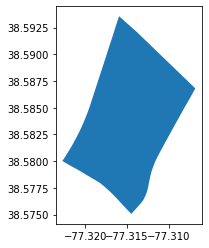

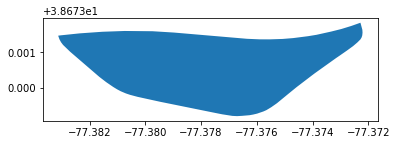

In [106]:
shp[shp['unique_id_1'] == '153315'].plot()
final[final['unique_id_1'] == '153609(CD 1)'].plot()

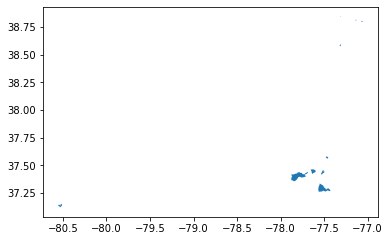

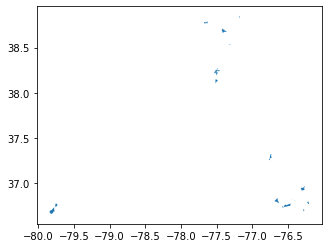

In [107]:
#important
shp[shp['unique_id_1'].isin(['041216',
 '041314',
 '041319',
 '041412',
 '059700',
 '153315',
 '510112',
 '510309',
 '750004',
 '760215'])].plot()
#059, 153, checked for more matches in counties, did not match
final[final['unique_id_1'].isin(['059513CD 11)',
 '089304(CD 5)',
 '089505(CD 5)',
 '095202(CD 1)',
 '095504(CD 1)',
 '153110(CD 1)',
 '153112(CD 1)',
 '153210(CD 1)',
 '153312(CD 1)',
 '153609(CD 1)',
 '177103(CD 1)',
 '177402(CD 1)',
 '177702(CD 1)',
 '177703(CD 1)',
 '177704(CD 1)',
 '550020(CD 3)',
 '550040',
 '550047',
 '650215(CD 2)',
 '710104(CD 2)',
 '800302(CD 3)',
 '800404(CD 3)',
 '800504(CD 3)',
 '800602(CD 3)'])].plot()

## Join election results and shapefile

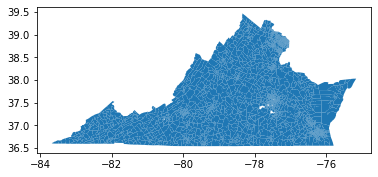

In [108]:
join = gpd.GeoDataFrame(pd.merge(df_with_absentee_reallocated, shp, on = 'unique_id_1', how = 'inner'), crs = proj)
join.plot()

In [109]:
join.shape[0]

2438

# Validation

## Shapefile comparison:

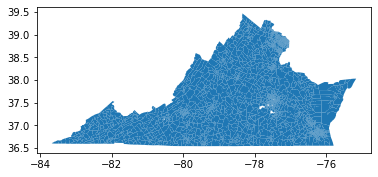

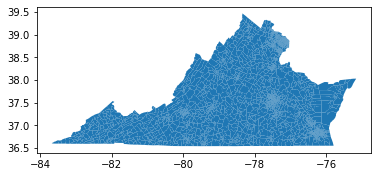

In [110]:
join.plot()
final.plot()

In [111]:
shp_final_merge = pd.merge(join, final, on = 'unique_id_1', how = 'outer', suffixes = ['_x', '_y'])

In [112]:
join['geometry'].geom_almost_equals(final['geometry'], decimal = 0)

/Users/lilyfalk/anaconda3/lib/python3.8/site-packages/geopandas/base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


0        True
1        True
2        True
3        True
4        True
        ...  
2458    False
2459    False
2460    False
2461    False
2462    False
Length: 2463, dtype: bool

They should be all in same order row wise because of unique_id - shp and shp final merge should match for all... clearly wrong order happening needs to be fixed

In [113]:
shp_shapes = gpd.GeoDataFrame(shp_final_merge, geometry = 'geometry_x')
final_shapes = gpd.GeoDataFrame(shp_final_merge, geometry = 'geometry_y')
vals = shp_shapes.geom_almost_equals(final_shapes, decimal = 0)

In [114]:
print(vals.value_counts())

True     1825
False     638
dtype: int64


153    42
059    42
107    38
550    33
700    24
       ..
630     1
730     1
007     1
680     1
830     1
Name: unique_id_1, Length: 92, dtype: int64


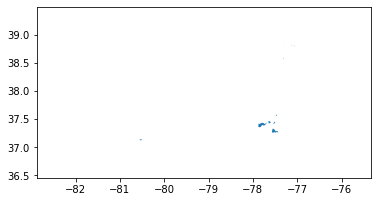

In [115]:
print(shp_final_merge[~vals]['unique_id_1'].str[0:3].value_counts())
diff_precincts = gpd.GeoDataFrame(shp_final_merge[~vals], geometry = 'geometry_x', crs = proj)

shp_difference = gpd.overlay(shp_shapes, final_shapes, how = 'symmetric_difference')
shp_difference.plot()

                     Pct       LOCALITY_x  G18USSDKAI_x  G18USSRSTE_x  \
9          601 - Accomac  Accomack County         498.0         528.0   
11          701 - Nandua  Accomack County         863.0         814.0   
12         801 - Bobtown  Accomack County         245.0         332.0   
13           802 - Melfa  Accomack County         409.0         328.0   
14    803 - Wachapreague  Accomack County         177.0         304.0   
...                  ...              ...           ...           ...   
2458                 NaN              NaN           NaN           NaN   
2459                 NaN              NaN           NaN           NaN   
2460                 NaN              NaN           NaN           NaN   
2461                 NaN              NaN           NaN           NaN   
2462                 NaN              NaN           NaN           NaN   

      G18USSLWAT_x  G18USSOWRI_x COUNTYFP_x countyfp_cd vtdst unique_id_x  \
9             12.0           0.0        001   

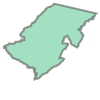

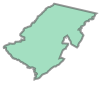

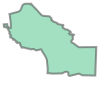

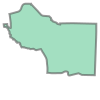

In [116]:
#Show a random difference
test = shp_final_merge[~vals].sample(axis = 0, n=1).index[0]
print(shp_final_merge[~vals])
display(shp_final_merge.iloc[test]['geometry_x'])
display(shp_final_merge.iloc[test]['geometry_y'])

test = shp_final_merge[~vals].sample(axis = 0).index[0]
display(shp_final_merge.iloc[test]['geometry_x'])
display(shp_final_merge.iloc[test]['geometry_y'])

### Look into county with FIPS 001

(16, 38)


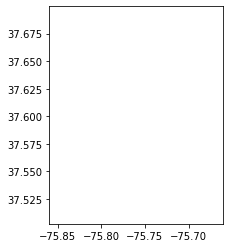

In [117]:
print(shp_final_merge[shp_final_merge['unique_id_1'].str[0:3] == '001'].shape)
ex_x = gpd.GeoDataFrame(shp_final_merge[shp_final_merge['unique_id_1'].str[0:3]== '001'], geometry = 'geometry_x', crs = proj)
ex_y = gpd.GeoDataFrame(shp_final_merge[shp_final_merge['unique_id_1'].str[0:3]== '001'], geometry = 'geometry_y', crs = proj)

gpd.overlay(ex_x, ex_y, how = 'symmetric_difference').plot()

## Election result comparison:

In [118]:
column_list = ['G18USSDKAI', 'G18USSRSTE', 'G18USSLWAT', 'G18USSOWRI']

In [119]:
final_df_merge = pd.merge(df_with_absentee_reallocated, final, on = 'unique_id_1', how = 'inner', suffixes = ('_x', '_y'))

In [120]:
#adapted from PDV training
def sum_checker(df, column_list):
    list_max = 0
    for i in column_list:
        left_sum = df[i+'_x'].sum()
        right_sum = df[i+'_y'].sum()
        if (left_sum == right_sum):
            print('column: ', i, ' have the same sums')
        
        else:
            diff = abs(left_sum - right_sum)
            percent = abs(left_sum - right_sum)/left_sum
            print('column: ', i)
            print('RDH sum is ', str(left_sum))
            print('Partner sum is ', str(right_sum))
            print('their (absolute) difference is ', str(diff))
            print('As a percentage of DF1 this is ', str(round(percent*100,5)) + '%')
            if (percent>list_max):
                list_max = percent
            print('')
    print('The max difference (as a percent of the total of on DF column is: ', str(round(list_max,5)))

In [121]:
sum_checker(final_df_merge, column_list)

column:  G18USSDKAI
RDH sum is  1910373.0
Partner sum is  1910370
their (absolute) difference is  3.0
As a percentage of DF1 this is  0.00016%

column:  G18USSRSTE  have the same sums
column:  G18USSLWAT
RDH sum is  61505.0
Partner sum is  61565
their (absolute) difference is  60.0
As a percentage of DF1 this is  0.09755%

column:  G18USSOWRI
RDH sum is  5350.0
Partner sum is  5509
their (absolute) difference is  159.0
As a percentage of DF1 this is  2.97196%

The max difference (as a percent of the total of on DF column is:  0.02972


In [122]:
#From Peter's MO
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff != 0):
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]['unique_id_1'])
                if (diff>max_diff):
                    max_diff = diff
                    #add line to check percent from total vote difference is
                    perc_diff_from_vest = (diff/df.iloc[j][right_Data])*100
                    print("New max diff is: ", str(max_diff))
                    print('% difference from VEST total is: ', str(perc_diff_from_vest))
                    print(df.iloc[j]['unique_id_1'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]['unique_id_1'])
        else:
            matching_rows +=1
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
        #add line for % of total vote that difference is
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 5")
    diff_list.sort()


In [123]:
validater_row(final_df_merge, column_list)

New max diff is:  1.0
% difference from VEST total is:  0.1798561151079137
001101
New max diff is:  2.0
% difference from VEST total is:  28.57142857142857
145401
There are  2462  total rows
1233  of these rows have election result differences
1229  of these rows are the same

The max difference between any one shared column in a row is:  2.0
The average difference is:  1.0006381620931717
There are  0 precinct results with a difference greater than 5


In [124]:
final_df_merge[final_df_merge['unique_id_1'] == '145401']

,Pct,LOCALITY_x,G18USSDKAI_x,G18USSRSTE_x,G18USSLWAT_x,G18USSOWRI_x,COUNTYFP_x,countyfp_cd,vtdst,unique_id_x,...,COUNTYFP_y,LOCALITY_y,VTDST,PRECINCT,G18USSDKAI_y,G18USSRSTE_y,G18USSLWAT_y,G18USSOWRI_y,geometry,unique_id_y
1749,401 - Powhatan Courthouse,Powhatan County,538.0,1572.0,34.0,5.0,145,145,401,145401,...,145,Powhatan County,000401,Powhatan Courthouse,538,1572,34,7,"POLYGON Z ((-77.96569 37.48880 0.00000, -77.96...",145401
